In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau  
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

## Fonctions pour afficher les différents métriques

In [2]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_display(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_display(ytrue, ypred)
    scores(ytrue,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

# Fonctions de perte
Il y deux types de fonctions de pertes très utilisées avec les réseaux siamois<br>
1. **Constrative Loss**, est utilisée avec en entrée un couple de données puis du label de ce couple. Si le couple est formé de données de même classe, c'est-à-dire des données normale alors le label du couple est de 0 sinon si le couple est formé de données dont l'une normale et l'autre anormale alors le label est 1

2. **Triplet Loss**, reçoit en entrée un triplet dont l'une est la donnée de reférence (donnée normale), le second est est une données positive, c'est-à-dire de même classe que le première et enfin le dernier est une donnée négative (données anormale). **Contrairement** Constrastive Loss, Triplet Loss ne reçoit pas de label. <br>

Un critère de similarité est utilisée dans le cas. Les plus couramment utilisé sont la **distance euclidienne** et **la similarité du cosinus**. Les foncrions de perte permettrons de minimiser la distance entre la distance entre deux données de la même classe (données normales) tout en maximaisant la distance entre deux données de classes différentes (données normale et anormale)


# Objectifs
1. Concevoir un reséau de neurones de types **Siamois**, Siamese Network en anglais.

2. Utiliser ces deux fonctions de perte afin de choisir celle qui fourni de meilleurs résulats.

3. Tester les deux critères de similirité pour chaque fonction de perte.

Au vu de nos objectifs, deux modèles de réseau seront mise en place l'une est **Twins Siamese** et l'autre est **Triplet Siamese**.

De même deux types de dataset seront mises en place afin de servir pour l'entraînement de chaque modèle de réseau de neurones

### Constrastive Loss


In [418]:
class ContrastiveLoss(nn.Module):
    """
    La fonction de perte Contrastive basée sur une métrique donnée. Dans notre cas, ça sera soit la distance euclidienne
    ou la similarité du cosinus.
    """

    def __init__(self, margin=1.0, similarity='euclidian'):
        """
        Nous avons le choix entre la similarité du cosinus et la distance euclidienne.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.similarity = similarity


    def forward(self, x0, x1, y):
        dist=None
        
        if self.similarity == 'cosine':
            assert len(x0.shape)==2 and len(x1.shape)==2, "x0 et x1 doivent être des tableux de 2 dimensions"
            
            dist=torch.empty(0,device=x0.device)
            #Sans la boucle il n'est pas ppssible de choisir la dimension sur laquelle 
            # nous comptons faire le produit scalaire, comme c'est le cas pour la somme ou pour d'autres opérations
            #"Unlike NumPy’s dot, torch.dot intentionally only supports computing the dot product of two 1D 
            #tensors with the same number of elements" commentaire de la documentation officielle
            for i in range(x0.size(0)): 
                input1,input2=x0[i],x1[i].T
                norm= torch.norm(input1) * torch.norm(input2)
                tensor=torch.tensor([input1 @ input2],device=input1.device)/norm
                dist=torch.cat((dist,tensor ),axis=0)

        elif self.similarity == 'euclidian':
            diff = x0 - x1
            dist_sq = torch.sum(torch.pow(diff, 2), 1)
            dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
    
        clamp = torch.clamp(mdist, min=0.0)
        loss =(1- y) * torch.pow(dist,2) + y * torch.pow(clamp, 2)
        loss = torch.sum(loss) / 2.0 / x0.size(0)
        
        return loss, clamp


### Triplet Loss

In [431]:
class TripletLoss(nn.Module):
    """
    La fonction de perte Contrastive basée sur une métrique donnée. Dans notre cas, ça sera soit la distance euclidienne
    ou la similarité du cosinus.
    """

    def __init__(self, margin=1.0, similarity='cosine'):
        """
        Nous avons le choix entre la similarité du cosinus et la distance euclidienne.
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.similarity = similarity


    def forward(self, x0, x1,x2):
        
        pos_dist=0.
        neg_dist=0.
        dist=None
        if self.similarity == 'euclidian':
            pos_diff = x0 - x1
            neg_diff = x0 - x2
            pos_dist_sq = torch.sum(torch.pow(pos_diff, 2), 1)
            neg_dist_sq = torch.sum(torch.pow(neg_diff, 2), 1)
            pos_dist = torch.sqrt(pos_dist_sq)
            neg_dist = torch.sqrt(neg_dist_sq)
            dist= pos_dist - neg_dist

        elif self.similarity=='cosine':
            assert len(x0.shape)==2 and len(x1.shape)==2 and len(x2.shape)==2, "x0 et x1 doivent être des tableux de 2 dimensions"
            
            dist=torch.empty(0,device=x0.device)
            #Sans la boucle il n'est pas ppssible de choisir la dimension sur laquelle 
            # nous comptons faire le produit scalaire, comme c'est le cas pour la somme ou pour d'autres opérations
            #"Unlike NumPy’s dot, torch.dot intentionally only supports computing the dot product of two 1D 
            #tensors with the same number of elements" commentaire de la documentation officielle
            for i in range(x0.size(0)): 
                input1,input2,input3=x0[i],x1[i].T,x2[i].T
                norm_pos= torch.norm(input1) * torch.norm(input2)
                norm_neg= torch.norm(input1) * torch.norm(input3)
                
                tensor=torch.tensor( [ input1 @ input2 ] ,device=x0.device)/norm_pos + torch.tensor( [ input1 @ input3 ] ,device=x0.device)/norm_neg
                dist=torch.cat((dist,tensor),axis=0)
 
        loss = torch.clamp(dist + self.margin, 0)
        loss = torch.sum(loss) / 2.0 / x0.size(0)
        
        return loss


### Dataset Pytorch pour entraîner Twin Siamese

In [329]:
class Consrastive_Torch_dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data,target):

        super(Consrastive_Torch_dataset,self).__init__()
        
        self.data = data
        self.targets = target

        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]
        

### Dataset Pytorch pour entraîner Triplet Siamese

In [330]:
class Triplet_Torch_dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data):

        super(Triplet_Torch_dataset,self).__init__()
        
        self.data = data

        
    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, index):
        return self.data[index]

### Prétraitement des données pour Twin Siamese

In [331]:
class ContrastiveDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):
        
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler
        
        torch.manual_seed(self.random_state)
        
        self.data = None
        self.target = None


        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()
   
        
    def get_scaler(self):
        return self.scaler
        
    def _load_data(self):
        self.data_ = pd.read_csv(self.file_path)
        

    def _preprocess_data(self):

        #postive : données normales
        #negative : données anormales (anomalies)
        
        self.data_.drop_duplicates(keep="last", inplace=True)
        # self.target = self.data_["Class"]
        self.positiv_=self.data_.loc[self.data_["Class"]==0,:]
        self.negativ=self.data_.loc[self.data_["Class"]==1,:]

        self.data_.drop(["Class", "Time"], axis=1,inplace=True)
        self.positiv_=self.positiv_.drop(["Class","Time"],axis=1).copy()
        self.negativ=self.negativ.drop(["Class","Time"],axis=1).copy()

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        n_sample,n_feature=self.negativ.shape # n_sample :nombre d'écahntillons des données négatives : données anormales
                                               # n_feature nombre de caractéristiques ou de variables
    
        if self.scaler is not None:
            
            scaled_positiv = self.scaler.fit_transform(self.positiv_)
            scaled_negativ = self.scaler.fit_transform(self.negativ)
            
            self.negativ = pd.DataFrame(scaled_negativ, columns=self.negativ.columns,index=self.negativ.index)
            self.positiv_ = pd.DataFrame(scaled_positiv, columns=self.positiv_.columns,index=self.positiv_.index)
            
            #Echantillonage des données positives de sorte à avoir le même nombre d'échantillons que les données négatives
            
            self.positiv0=self.positiv_.sample(n=n_sample,random_state=42)
            self.positiv1=self.positiv_.drop(index=self.positiv0.index).sample(n=n_sample,random_state=42)

            
        
        neg, pos0,pos1=[],[],[]
        
        
        #Création de paires de données (positive-positive) et (positive-negative)
        for line in range(n_sample):
            neg_serie=self.negativ.iloc[line,0:n_feature].to_list()
            pos_serie0=self.positiv0.iloc[line,0:n_feature].to_list()
            pos_serie1=self.positiv1.iloc[line,0:n_feature].to_list()
            neg.append(neg_serie)
            pos0.append(pos_serie0)
            pos1.append(pos_serie1)

        pos_neg=[ [pos0[i],neg[j]] for i in range(len(pos0)) for j in range(len(neg))]
        pos_neg_tensor=torch.tensor(pos_neg,dtype=torch.float32)

        pos_pos=[ [pos0[i],pos1[j]] for i in range(len(pos0)) for j in range(len(neg))]
        pos_pos_tensor=torch.tensor(pos_pos,dtype=torch.float32)

        self.data=torch.cat((pos_pos_tensor,pos_neg_tensor),axis=0)

        #Creation de labels
        pos_labels=[0 for i in range(pos_pos_tensor.size(0))]
        neg_labels=[1 for i in range(pos_neg_tensor.size(0))]
        labels=pos_labels+neg_labels
        self.target=torch.tensor(labels,dtype=torch.float32)

        #Shuffle les données 

        indices=torch.randperm(self.data.size(0))
        self.data=self.data[indices]
        self.target=self.target[indices]

         

    def _split_data(self):
        
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

### Prétraitement des données pour Triplet Siamese

In [332]:
class TripletDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):
        
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler
        
        torch.manual_seed(self.random_state)
        
        self.data = None
        self.target = None


        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()
   
        
    def get_scaler(self):
        return self.scaler
        
    def _load_data(self):
        self.data_ = pd.read_csv(self.file_path)
        

    def _preprocess_data(self):

        #postive : données normales
        #negative : données anormales (anomalies)
        
        self.data_.drop_duplicates(keep="last", inplace=True)
        # self.target = self.data_["Class"]
        self.positiv_=self.data_.loc[self.data_["Class"]==0,:]
        self.negativ=self.data_.loc[self.data_["Class"]==1,:]

        self.data_.drop(["Class", "Time"], axis=1,inplace=True)
        self.positiv_=self.positiv_.drop(["Class","Time"],axis=1).copy()
        self.negativ=self.negativ.drop(["Class","Time"],axis=1).copy()

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        n_sample,n_feature=self.negativ.shape # n_sample :nombre d'écahntillons des données négatives : données anormales
                                               # n_feature nombre de caractéristiques ou de variables
    
        if self.scaler is not None:
            
            scaled_positiv = self.scaler.fit_transform(self.positiv_)
            scaled_negativ = self.scaler.fit_transform(self.negativ)
            
            self.negativ = pd.DataFrame(scaled_negativ, columns=self.negativ.columns,index=self.negativ.index)
            self.positiv_ = pd.DataFrame(scaled_positiv, columns=self.positiv_.columns,index=self.positiv_.index)
            
            #Echantillonage des données positives de sorte à avoir le même nombre d'échantillons que les données négatives
            
            self.positiv0=self.positiv_.sample(n=n_sample,random_state=42)
            self.positiv1=self.positiv_.drop(index=self.positiv0.index).sample(n=n_sample,random_state=42)

            
        
        neg, pos0,pos1=[],[],[]
        
        
        #Création de paires de données (positive-positive) et (positive-negative)
        for line in range(n_sample):
            neg_serie=self.negativ.iloc[line,0:n_feature].to_list()
            pos_serie0=self.positiv0.iloc[line,0:n_feature].to_list()
            pos_serie1=self.positiv1.iloc[line,0:n_feature].to_list()
            neg.append(neg_serie)
            pos0.append(pos_serie0)
            pos1.append(pos_serie1)

        triplet=[ [pos0[i],pos1[j],neg[j] ] for i in range(len(pos0)) for j in range(len(neg))]
        self.data=torch.tensor(triplet,dtype=torch.float32)

        #Shuffle les données 

        indices=torch.randperm(self.data.size(0))
        self.data=self.data[indices]

         

    def _split_data(self):
        
        self.xtrain, self.xtest = train_test_split(
            self.data, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain

    def get_test_data(self):
        return self.xtest

## Backbone
Un réseau de neurones **Siamois** est constitué de deux reséaux pour **Twin Siamese** et trois pour **Triplet Siamese**. <br>Ces différents réseaux ont exactement les **même configurations** et les **les mêmes poids**.<br>
Notre **Backbone** est celui qui sera utiliser dans la mise en place de ces différents réseaux.

In [333]:
class Backbone(nn.Module):

    def __init__(self,input_size: int, latent_size: int,dropout: float) -> None:

        super(Backbone,self).__init__()
        
        self.fc1=nn.Linear(in_features=input_size,out_features=25)
        self.residual1=nn.Linear(in_features=input_size,out_features=20)
        self.layer_norm1=nn.LayerNorm(25)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=25,out_features=20)
        self.layer_norm2=nn.LayerNorm(20)
        self.relu2=nn.ReLU()
        self.residual2=nn.Linear(in_features=20,out_features=latent_size)
        self.fc3=nn.Linear(in_features=20,out_features=15)
        self.layer_norm3=nn.LayerNorm(15)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=15,out_features=latent_size)
        self.classifier=nn.Linear(in_features=latent_size,out_features=2)

    def forward(self,inputs: Tensor) -> Tensor:
        
        x=self.relu1(self.layer_norm1(self.fc1(inputs)))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm2(self.fc2(x)+residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm3(self.fc3(x)))
        x=self.dropout2(x)
        x=self.fc4(x) +residual2
        x=self.classifier(x)

        return x
    
    


## Twins Siamese Network
Conception de notre réseau **Twin Siamese** constitué de deux deux réeseaux **backbone** ayant les **mêmes poids**

In [334]:
class Twins_Siamese(nn.Module):

    def __init__(self,input_size: int,latent_size: int,contamination: float=0.02,dropout: float=0.1,device: str="cuda",margin=0.1) -> None:

        super(Twins_Siamese,self).__init__()
        
    
        self.backbone=Backbone(input_size=input_size, latent_size = latent_size,dropout=dropout)
        
        self.latent_size=latent_size
        self.offset=contamination
        self.margin=margin
        self.epoch=1
        
        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")
        self.is_fitted=False

        self.train_loss=[]
        self.val_loss=[]

    def forward(self,input1,input2):

        out1=self.backbone.forward(input1)
        out2=self.backbone.forward(input2)
        return out1, out2
    
    def train_one_epoch(self,train_loader:DataLoader,optimizer,loss_fn,scheduler):
        
        """The function is use to train one epoch of the model
            Args: 
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader
                
        """
        last_loss=0 # Computing loss per batch
        running_loss=0
        accuracy_score=0
        if loss_fn.margin !=self.margin:
            loss_fn=ContrastiveLoss(margin=self.margin)
        
        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad()
            data,target=batch[0],batch[1].to(self.device)
            input1,input2=data[:,0,:].to(self.device),data[:,1,:].to(self.device)
            out1,out2=self.forward(input1,input2)

            loss,dist=loss_fn(out1,out2,target)
            y_pred=torch.where(dist > 0, torch.tensor(0),torch.tensor(1))
            accuracy_score+=torch.sum(y_pred==target)
            loss.backward()

            running_loss+=loss.item()

            optimizer.step()
        
            
            if batch_index%100==99:
                last_loss=running_loss/100 # Computing loss per batch
                running_loss=0
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        # 
        if self.epoch %10==0:
            # before_lr = Gen_optimizer.param_groups[0]["lr"]
            scheduler.step()
    
            # after_lr = Gen_optimizer.param_groups[0]["lr"]
            # print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_loss,100*accuracy_score/(train_loader.batch_size*len(train_loader))
    
    def validation_one_epoch(self,validation_loader,loss_fn):

        """The function is used to train one epoch of the model
            Args:
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader

        """
        avg_vloss = 0.
        running_loss=0.
        accuracy_score=0.
    
        with torch.no_grad() :
    
            
            for batch in validation_loader:


                data,target=batch[0],batch[1].to(self.device)
                input1,input2=data[:,0,:].to(self.device),data[:,1,:].to(self.device)
                out1,out2=self.forward(input1,input2)

                loss,dist=loss_fn(out1,out2,target)

                running_loss+=loss.item()
                y_pred=torch.where(dist > 0, torch.tensor(0),torch.tensor(1))
                accuracy_score+=torch.sum(y_pred==target)

        n=len(validation_loader)*validation_loader.batch_size
        return running_loss/n, 100*accuracy_score/n

    def predict(self, dataloader: DataLoader):
        self.eval()
        loss_fn=ContrastiveLoss(self.margin)
        predicted_labels=torch.empty(0)
        true_labels=torch.empty(0)

        with torch.no_grad() :
    
            for batch in dataloader:

                data,target=batch[0],batch[1].to(self.device)
                input1,input2=data[:,0,:].to(self.device),data[:,1,:].to(self.device)
                out1,out2=self.forward(input1,input2)

                _,dist=loss_fn(out1,out2,target)
                y_pred=torch.where(dist > 0, torch.tensor(0),torch.tensor(1))
                predicted_labels=torch.cat((predicted_labels,y_pred.cpu()),dim=0)
                true_labels=torch.cat((true_labels,target.cpu()),dim=0)

        return pd.Series(predicted_labels),pd.Series(true_labels)

    
    def getEpoch(self):
        return self.epoch
    
    def getMargin(self):
        return self.margin
        
    def fit(self,train_loader,validation_loader,optimizer,scheduler,loss_fn=ContrastiveLoss(),epochs=10,device="cuda"):
        self.epoch=epochs
        """The function is used to train the model through many epochs
            Args: 
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return
                
        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
        
            print("EPOCHS : {}".format(epoch +1))
            self.backbone.train(True) # Activate training mode
            avg_loss, train_acc=self.train_one_epoch(train_loader,optimizer,loss_fn,scheduler) # training the model on an epoch

            self.backbone.eval()
            avg_vloss,val_acc=self.validation_one_epoch(validation_loader,loss_fn) # training the model on an epoch
            
            
            print(f"Train Loss {round(avg_loss,9)} - Val Loss  {round(avg_vloss,9)} - Train Acc {round(train_acc.item(),3)} - Val Acc {round(val_acc.item(),3)}")
            self.train_loss.append(avg_loss)
            self.val_loss.append(avg_vloss)
        

            if avg_vloss < best_avg_vloss :
                best_avg_vloss=avg_vloss
                model_path='/home/dah/anomalie_detection/anomalie_detection/models/model_Siamese_{}'.format(datetime.now().strftime('%Y%m%d_%H%')) 
                torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
            self.epoch+=1
        self.is_fitted=True

        return {
            "train_loss":self.train_loss,
            "validation_loss":self.val_loss
        }
                

## Triplet Siamese Network
Conception de notre réseau **Triplet Siamese** constitué de **trois** réeseaux **backbone** ayant les **mêmes poids**

In [335]:
class Triplet_Siamese(nn.Module):

    def __init__(self,input_size: int,latent_size: int,dropout: float=0.1,device: str="cuda",margin=1.0) -> None:

        super(Triplet_Siamese,self).__init__()
        
    
        self.backbone=Backbone(input_size=input_size, latent_size = latent_size,dropout=dropout)
        
        self.latent_size=latent_size
        self.margin=margin
        self.epoch=1
        
        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")
        self.is_fitted=False

        self.train_loss=[]
        self.val_loss=[]

    def forward(self,input1,input2,input3):

        out1=self.backbone.forward(input1)
        out2=self.backbone.forward(input2)
        out3=self.backbone.forward(input3)
        return out1, out2,out3
    
    def train_one_epoch(self,train_loader:DataLoader,optimizer,loss_fn,scheduler):
        
        """The function is use to train one epoch of the model
            Args: 
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader
                
        """
        last_loss=0 # Computing loss per batch
        running_loss=0
        if loss_fn.margin !=self.margin:
            loss_fn=TripletLoss(margin=self.margin)
        
        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad()
        
            input1,input2,input3=batch[:,0,:].to(self.device),batch[:,1,:].to(self.device),batch[:,2,:].to(self.device)
            out1,out2,out3=self.forward(input1,input2,input3)

            loss=loss_fn(out1,out2,out3)
            loss.backward()

            running_loss+=loss.item()

            optimizer.step()
        
            
            if batch_index%100==99:
                last_loss=running_loss/100 # Computing loss per batch
                running_loss=0
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        # # 
        # if self.epoch %10==0:
        #     # before_lr = Gen_optimizer.param_groups[0]["lr"]
        #     # scheduler.step()
    
        #     # after_lr = Gen_optimizer.param_groups[0]["lr"]
        #     # print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_loss
    
    def validation_one_epoch(self,validation_loader,loss_fn):

        """The function is used to train one epoch of the model
            Args:
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader

        """
        running_loss=0.

        with torch.no_grad() :
    
            
            for batch in validation_loader:

                input1,input2,input3=batch[:,0, :].to(self.device),batch[:,1,:].to(self.device), batch[:,2,:].to(self.device)
                out1,out2,out3=self.forward(input1,input2,input3)

                loss=loss_fn(out1,out2,out3)
                running_loss+=loss.item()

        return running_loss/len(validation_loader)


    
    def getEpoch(self):
        return self.epoch
    
    def getMargin(self):
        return self.margin
        
    def fit(self,train_loader,validation_loader,optimizer,scheduler,loss_fn=TripletLoss(margin=1.0),epochs=10,device="cuda"):
        
        """The function is used to train the model through many epochs
            Args: 
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return
                
        """
        self.epoch=epochs
        assert isinstance(loss_fn,TripletLoss), "Erreur de fonction de perte, Elle doit être TripletLoss"
        self.to(self.device)

        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
        
            print("EPOCHS : {}".format(epoch +1))
            self.backbone.train(True) # Activate training mode
            avg_loss=self.train_one_epoch(train_loader,optimizer,loss_fn,scheduler) # training the model on an epoch

            self.backbone.eval()
            avg_vloss=self.validation_one_epoch(validation_loader,loss_fn) # training the model on an epoch
            
            
            print(f"Train Loss {avg_loss} - Val Loss  {avg_vloss}")
            self.train_loss.append(avg_loss)
            self.val_loss.append(avg_vloss)
        

            if avg_vloss < best_avg_vloss :
                best_avg_vloss=avg_vloss
                model_path='/home/dah/anomalie_detection/anomalie_detection/models/model_Siamese_{}'.format(datetime.now().strftime('%Y%m%d_%H%')) 
                torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
            self.epoch+=1
        self.is_fitted=True

        return {
            "train_loss":self.train_loss,
            "validation_loss":self.val_loss
        }
                

### Twins Siamese Training

In [400]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset 
dataset = ContrastiveDataset(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv",scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = Consrastive_Torch_dataset(xtrain,ytrain)
pytorch_test_dataset = Consrastive_Torch_dataset(xtest,ytest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

### Constrastive Loss avec distance euclidienne

In [405]:
#Creation de modèle
model_eucl=Twins_Siamese(input_size=29,latent_size=10,contamination=0.02,dropout=0.2,device="cuda",margin=1.0)

In [406]:
similarity=["cosine","euclidian"]
#Optimiseur 
optimizer=optim.Adam(lr=1e-4, params=model_eucl.parameters()) # Optimiseur

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


loss_fn=ContrastiveLoss(margin=model_eucl.getMargin(),similarity=similarity[1]) # La fonction de perte
# recons_loss=nn.SmoothL1Loss()
# recons_loss=nn.MSELoss()

history=model_eucl.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=5) # Entraînement du modèle


EPOCHS : 1
Train Loss 8.5153e-05 - Val Loss  3.657e-06 - Train Acc 96.762 - Val Acc 99.999
EPOCHS : 2
Train Loss 1.429e-05 - Val Loss  5.55e-07 - Train Acc 99.925 - Val Acc 99.999
EPOCHS : 3
Train Loss 3.371e-06 - Val Loss  1.02e-07 - Train Acc 99.972 - Val Acc 99.999
EPOCHS : 4
Train Loss 7.96e-07 - Val Loss  4e-08 - Train Acc 99.979 - Val Acc 99.999
EPOCHS : 5
Train Loss 4.85e-07 - Val Loss  2e-08 - Train Acc 99.982 - Val Acc 99.999


In [409]:
predicted_labels,true_labels=model_eucl.predict(test_loader)


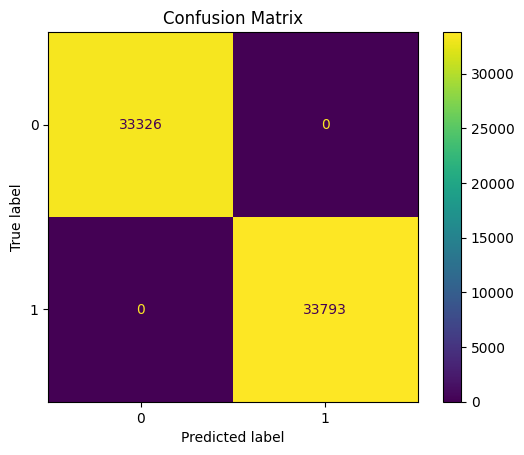

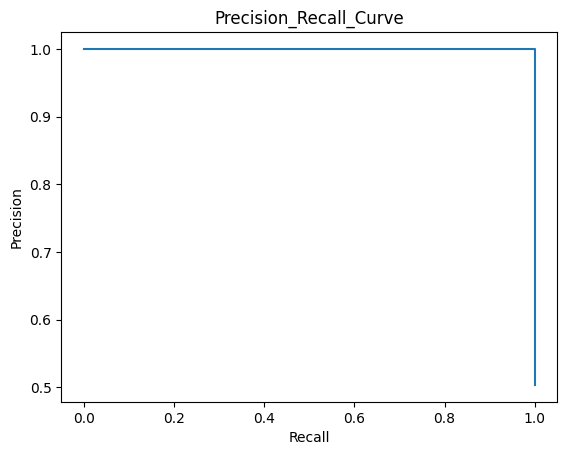

roc_auc 1.0


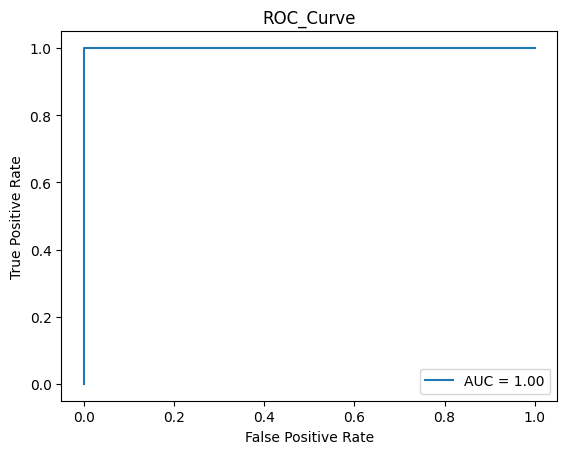

   f1_score  accuracy_score  precision_score  recall_score
0       1.0             1.0              1.0           1.0


In [410]:
evaluation(true_labels,predicted_labels)

### Constrastive Loss avec la similarité du cosinus

In [419]:
#Creation de modèle
model_cos=Twins_Siamese(input_size=29,latent_size=10,contamination=0.02,dropout=0.2,device="cuda",margin=1.0)

In [420]:
similarity=["cosine","euclidian"]
#Optimiseur 
optimizer=optim.Adam(lr=1e-4, params=model_cos.parameters()) # Optimiseur

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


loss_fn=ContrastiveLoss(margin=model_cos.getMargin(),similarity=similarity[0]) # La fonction de perte
# recons_loss=nn.SmoothL1Loss()
# recons_loss=nn.MSELoss()

history=model_cos.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=20) # Entraînement du modèle


EPOCHS : 1
Train Loss 0.253192614 - Val Loss  0.024825934 - Train Acc 48.267 - Val Acc 31.275
EPOCHS : 2
Train Loss 0.253195138 - Val Loss  0.024825933 - Train Acc 46.186 - Val Acc 37.296
EPOCHS : 3
Train Loss 0.253196191 - Val Loss  0.024825934 - Train Acc 46.711 - Val Acc 38.416
EPOCHS : 4
Train Loss 0.253197234 - Val Loss  0.024825934 - Train Acc 47.156 - Val Acc 40.65
EPOCHS : 5
Train Loss 0.253197981 - Val Loss  0.024825935 - Train Acc 47.961 - Val Acc 43.953
EPOCHS : 6
Train Loss 0.253198444 - Val Loss  0.024825935 - Train Acc 48.689 - Val Acc 45.712
EPOCHS : 7
Train Loss 0.253198724 - Val Loss  0.024825935 - Train Acc 49.068 - Val Acc 45.891
EPOCHS : 8
Train Loss 0.25319901 - Val Loss  0.024825934 - Train Acc 49.455 - Val Acc 48.199
EPOCHS : 9
Train Loss 0.253199251 - Val Loss  0.024825934 - Train Acc 49.464 - Val Acc 48.968
EPOCHS : 10
Train Loss 0.253199367 - Val Loss  0.024825934 - Train Acc 49.586 - Val Acc 49.736
EPOCHS : 11
Train Loss 0.253199509 - Val Loss  0.024825934 - 

### Triplet Siamese Training

In [421]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset 
dataset = TripletDataset(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv",scaler=MinMaxScaler())

xtrain= dataset.get_train_data()
xtest= dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = Triplet_Torch_dataset(xtrain)
pytorch_test_dataset = Triplet_Torch_dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

### Triplet Loss avec distance euclidienne

In [424]:
#Creation de modèle
model_e=Triplet_Siamese(input_size=29,latent_size=10,dropout=0.2,device="cuda",margin=1.0)

In [425]:
similarity=["cosine","euclidian"]
#Optimiseur 
optimizer=optim.Adam(lr=1e-4, params=model_e.parameters()) # Optimiseur

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


loss_fn=TripletLoss(margin=model_e.getMargin(),similarity=similarity[1]) # La fonction de perte

history=model_e.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=10) # Entraînement du modèle


EPOCHS : 1
Train Loss 0.00020595033915014936 - Val Loss  0.0
EPOCHS : 2
Train Loss 3.090601006988436e-05 - Val Loss  0.0
EPOCHS : 3
Train Loss 3.1786857289262115e-06 - Val Loss  0.0
EPOCHS : 4
Train Loss 0.0 - Val Loss  0.0
EPOCHS : 5
Train Loss 0.0 - Val Loss  0.0
EPOCHS : 6
Train Loss 0.0 - Val Loss  0.0
EPOCHS : 7
Train Loss 0.0 - Val Loss  0.0
EPOCHS : 8
Train Loss 9.002005972433835e-06 - Val Loss  0.0
EPOCHS : 9
Train Loss 0.0 - Val Loss  0.0
EPOCHS : 10
Train Loss 0.0 - Val Loss  0.0


### Triplet Loss avec la similarité du cosinus

In [435]:
#Creation de modèle
model_c=Triplet_Siamese(input_size=29,latent_size=10,dropout=0.2,device="cuda",margin=0.4)

In [436]:
similarity=["cosine","euclidian"]
#Optimiseur 
optimizer=optim.RMSprop(lr=1e-4, params=model_c.parameters()) # Optimiseur

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

loss_fn=TripletLoss(margin=model_c.getMargin(),similarity=similarity[0]) # La fonction de perte

history=model_c.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=20) # Entraînement du modèle


EPOCHS : 1
Train Loss 1.1999902653694152 - Val Loss  1.1999999859833177
EPOCHS : 2
Train Loss 1.199998940229416 - Val Loss  1.2000000494242566
EPOCHS : 3
Train Loss 1.1999997043609618 - Val Loss  1.2000000478968433
EPOCHS : 4
Train Loss 1.1999999177455902 - Val Loss  1.2000000481099706
EPOCHS : 5
Train Loss 1.1999999284744263 - Val Loss  1.200000049459778
EPOCHS : 6
Train Loss 1.1999999284744263 - Val Loss  1.2000000490690443
EPOCHS : 7
Train Loss 1.1999999296665191 - Val Loss  1.2000000480389283
EPOCHS : 8
Train Loss 1.199999930858612 - Val Loss  1.2000000483586195
EPOCHS : 9
Train Loss 1.199999930858612 - Val Loss  1.2000000498860328
EPOCHS : 10
Train Loss 1.19999995470047 - Val Loss  1.2000000480744495
EPOCHS : 11
Train Loss 1.1999999380111694 - Val Loss  1.2000000485362257
EPOCHS : 12
Train Loss 1.199999930858612 - Val Loss  1.2000000479323645
EPOCHS : 13
Train Loss 1.199999965429306 - Val Loss  1.2000000479678858
EPOCHS : 14
Train Loss 1.1999999368190766 - Val Loss  1.200000050596

### Visualisation des des learnings curves sur le jeu de données d'entraînement et de validation.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

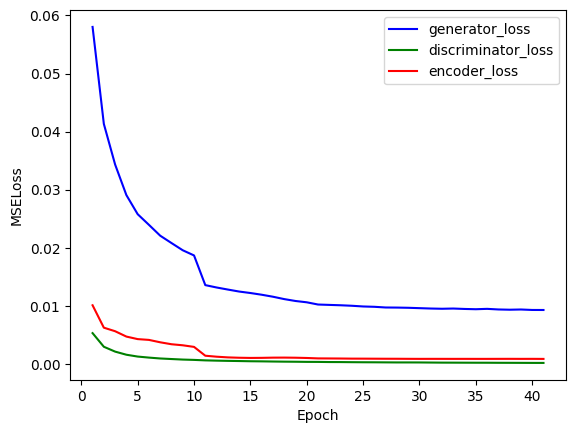

In [ ]:
n=len(history['generator_loss'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['generator_loss'],label="generator_loss",color='blue')
plt.plot(epoch,history['discriminator_loss'],label="discriminator_loss",color='green')
plt.plot(epoch,history['encoder_loss'],label="encoder_loss",color='red')

plt.ylabel("MSELoss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

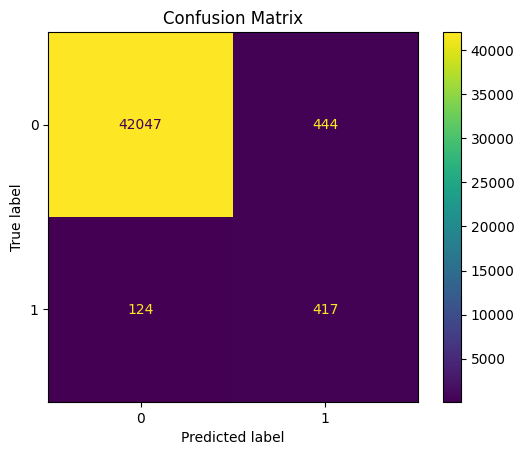

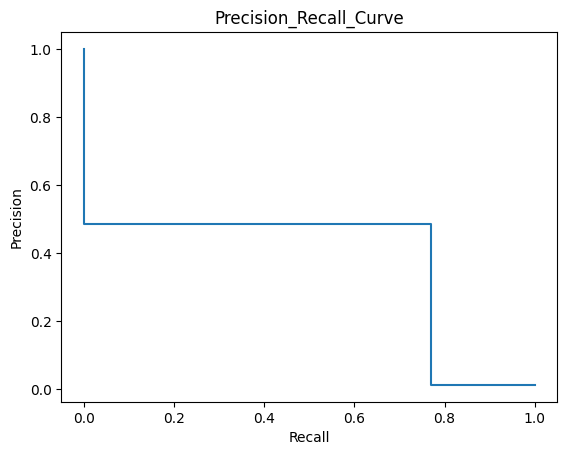

roc_auc 0.880172776394401


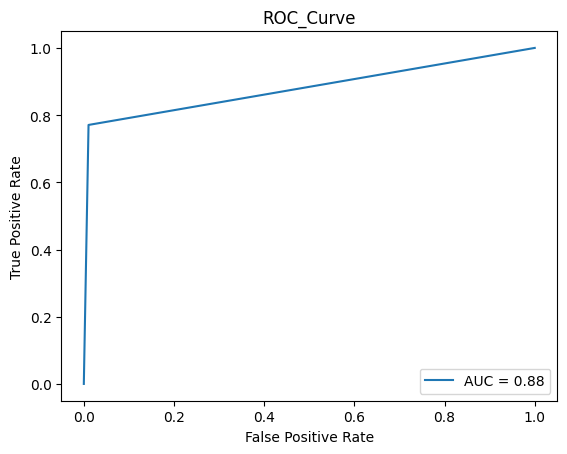

   f1_score  accuracy_score  precision_score  recall_score
0  0.594864        0.986801         0.484321      0.770795


In [ ]:
torch.manual_seed(42)
criterion=nn.L1Loss(reduction='none')
ypred=model.predict(test_loader,0.02,criterion=criterion)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

#### Questions
1. Combien de couche utilisé dans notre couche d'encodeur ?
2. Quelle dimension pour la variable latente(la dimension de des donnée à la sortie des de la couche d'encodeur) ?
3. Quelle est la bonne initialisation des poids de notre réseaux (Quelle fonction utilisée) ?
4. Quel algo d'optimization utilisé (SGD, Adam, ...)?
5. Quelle fonction d'activation utilisée ?
6. Quelle pourcentage de contamination utilisé ?
7. Comment détecter des problèmes de vanishing ou exploding gradient ?

## Référence
https://arxiv.org/pdf/1805.06725.pdf <br>
https://github.com/samet-akcay/ganomaly/blob/master/options.py <br>


meiller params : w_recons=40, dropout=0.2,recons_loss=SmoothL1,  tp=421, loss_fn=L1Loss <br>
gen_loss= 1*loss_fn(z_real2,z_fake2) + 3*loss_fn(real_outputs2.to(self.device),fake_output2) + 40*recons_loss(real_data,fake_data2)